# Version information

In [1]:
from datetime import date
print("Running date:", date.today().strftime("%B %d, %Y"))
import pyleecan
print("Pyleecan version:" + pyleecan.__version__)
import SciDataTool
print("SciDataTool version:" + SciDataTool.__version__)
# %matplotlib notebook
# import matplotlib
# # matplotlib.use('Agg')
# matplotlib.use('Agg')

path = 'C:/Users/TH/Desktop/NGV_NVH_skku'
model = 'IPMSM8P48S1.json'
modelname = 'IPMSM8P48S1'

Running date: July 03, 2022
Pyleecan version:1.3.9
SciDataTool version:2.4.9


# Force Module을 사용하여 자기력을 계산하는 방법

이 튜토리얼은 pyleecan으로 **자기력을 계산**하는 다양한 단계를 보여줍니다.

SciDataTool 개체의 기능과 사용법을 설명하기 위해 FEMM뮬레이션을 실행하고 전류를 인가하여 실행 시간을 줄이기 위해 주기성과 병렬연산을 사용합니다.

C:/Users/TH/anaconda3/envs/py38_pyleecan/Lib/site-packages/pyleecan/Data


C:\Users\TH\anaconda3\envs\py38_pyleecan\lib\site-packages\pyleecan\Methods\Machine\Machine\plot.py:187: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(<Figure size 576x576 with 1 Axes>,
 <AxesSubplot:title={'center':'IPMSM8P48S_1'}, xlabel='Position along x-axis [m]', ylabel='Position along y-axis [m]'>)

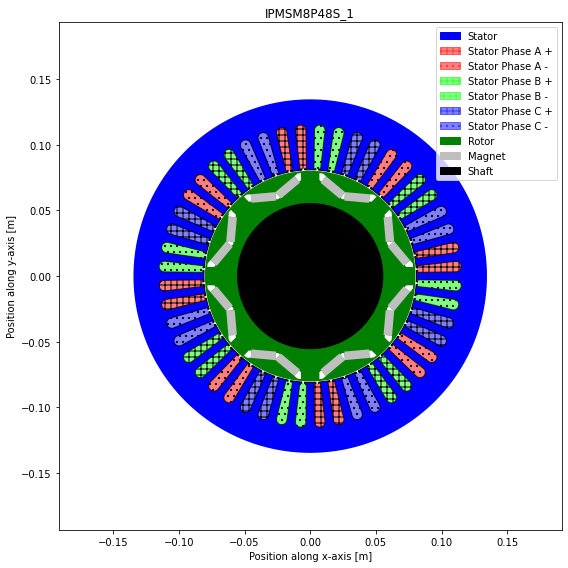

In [3]:
%matplotlib inline

# Load the machine
from os.path import join
from pyleecan.Functions.load import load
from pyleecan.definitions import DATA_DIR
print(DATA_DIR)

from os.path import join
from numpy import (
    zeros,
    exp,
    pi,
    real,
    meshgrid,
    mean,
)

# 힘 계산 클래스 추가
from pyleecan.Classes.ForceMT import ForceMT
from pyleecan.Classes.OPdq import OPdq
from pyleecan.Classes.Simu1 import Simu1
from pyleecan.Classes.MagFEMM import MagFEMM
from pyleecan.Classes.InputCurrent import InputCurrent

from pyleecan.Functions.load import load
from pyleecan.Functions.Plot import dict_2D, dict_3D 
from pyleecan.definitions import DATA_DIR   


# Load machine
femm_model = load(join(path,model))
femm_model.plot()

## Simu 1 Simulation (No-load)

In [28]:
simu1 = Simu1(name="IPMSM_AGSF_spectrum_sym", machine=femm_model)
simu1.input = InputCurrent(
    OP=OPdq(Id_ref=0, Iq_ref=0, N0=2000),
    Ir=None,
    Na_tot=2 ** 10, # angle 
    Nt_tot=2 ** 8, #Time
)

simu1.elec = None

simu1.mag = MagFEMM(
    type_BH_stator=0,  # 0 to use the material B(H) curve, 
    type_BH_rotor=0,   # 0 to use the material B(H) curve, 
    is_periodicity_a=True,
    is_periodicity_t=True,
)
simu1.force = ForceMT(
    is_periodicity_a=True,
    is_periodicity_t=True,
)


simu1.mag.is_get_meshsolution = True # To get FEA mesh for latter post-procesing
simu1.mag.is_save_meshsolution_as_file = True # To save FEA results in a dat file


simu1.mag.nb_worker = 8
out_noload = simu1.run()
AGSF_noload = out_noload.force.AGSF 


[11:34:40] Starting running simulation IPMSM_AGSF_spectrum_sym (machine=IPMSM8P48S_1)
[11:34:40] Starting Magnetic module
[11:34:41] Computing Airgap Flux in FEMM
[11:34:45] Starting Force module
[11:34:45] End of simulation IPMSM_AGSF_spectrum_sym


## Simu2 simulation (Load)


In [29]:
# 부하 해석

import math

simu2 = Simu1(name="IPMSM_AGSF_spectrum_load", machine=femm_model)
N0=2000
# I0, Phi0 설정
I0_rms = 250/math.sqrt(2) # Maximum current [Arms]
Phi0 = 140*pi/180  # Maximum Torque Per Amp

# 해당 Id/Iq 계산
Id_ref = (I0_rms*exp(1j*Phi0)).real
Iq_ref = (I0_rms*exp(1j*Phi0)).imag

#정현파 전류의 정의 (OPdq)
simu2.input = InputCurrent(
    OP=OPdq(Id_ref=Id_ref, Iq_ref=Iq_ref, N0=N0),
    Ir=None,
    Na_tot=2 ** 10, # angle
    Nt_tot=2 ** 8, #Time
)

simu2.elec = None

simu2.mag = MagFEMM(
    type_BH_stator=0,
    type_BH_rotor=0,
    is_periodicity_a=True,
    is_periodicity_t=True,
)
simu2.force = ForceMT(
    is_periodicity_a=True,
    is_periodicity_t=True,
)

simu2.mag.is_get_meshsolution = True # To get FEA mesh for latter post-procesing
simu2.mag.is_save_meshsolution_as_file = True # To save FEA results in a dat file


simu2.mag.nb_worker = 8
out_load = simu2.run()
AGSF_load = out_load.force.AGSF # data postcalculation





[11:34:50] Starting running simulation IPMSM_AGSF_spectrum_load (machine=IPMSM8P48S_1)
[11:34:50] Starting Magnetic module
[11:34:51] Computing Airgap Flux in FEMM
[11:34:54] Starting Force module
[11:34:54] End of simulation IPMSM_AGSF_spectrum_load


In [30]:
# 자속 밀도 분포도 확인

# out_noload.mag.meshsolution.plot_contour(label="B", clim=[0,2])
# out_load.mag.meshsolution.plot_contour(label="B", clim=[0,2])


# Plot &  Data Check(Load) -3D Airgap Flux density (One rotation,Oneperiod, Smallestperiod)

C:\Users\TH\anaconda3\envs\py38_pyleecan\lib\site-packages\SciDataTool\Functions\Plot\plot_3D.py:374: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


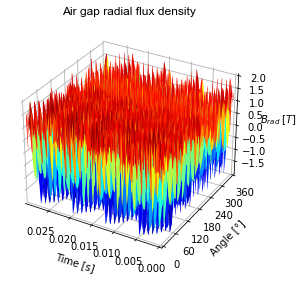

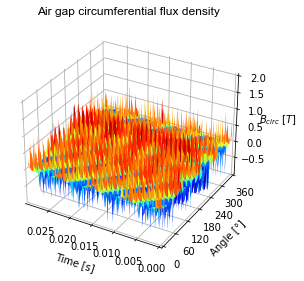

In [31]:
# 기계적 한주기 및 한바퀴 
out_load.mag.B.plot_3D_Data("time", "angle{°}", is_2D_view=False,z_max=2)

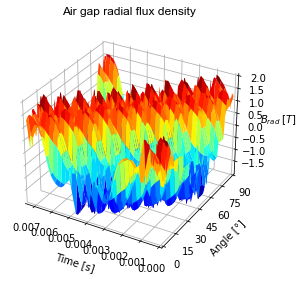

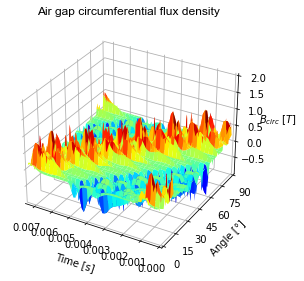

In [32]:
# 전기적 한주기
out_load.mag.B.plot_3D_Data("time[oneperiod]", "angle[oneperiod]{°}", is_2D_view=False,z_max=2)

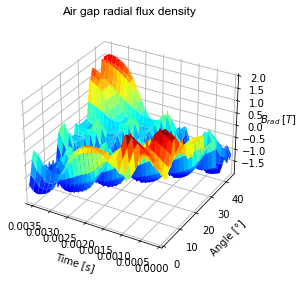

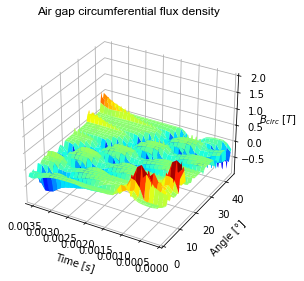

In [33]:
# 전기적 1/2 주기 (최소)
out_load.mag.B.plot_3D_Data("time[smallestperiod]", "angle[smallestperiod]{°}", is_2D_view=False, z_max=2)

## Data check(Load) 공간 자속밀도분포(공극) 

### Spatial Distribution

C:\Users\TH\anaconda3\envs\py38_pyleecan\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:539: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\TH\anaconda3\envs\py38_pyleecan\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:539: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


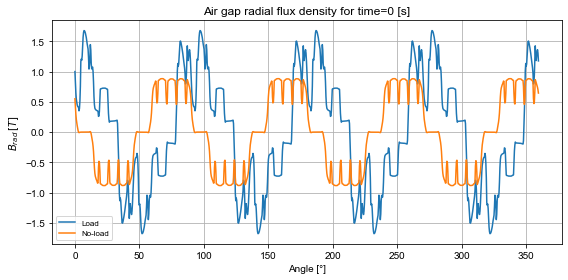

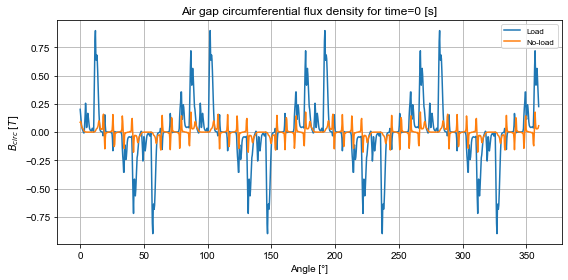

In [34]:
# 공간적 자속 밀도 분포도 비교
out_load.mag.B.plot_2D_Data("angle{°}",data_list=[out_noload.mag.B],legend_list=['Load','No-load'])

### Temporal Distribution

C:\Users\TH\anaconda3\envs\py38_pyleecan\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:539: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\TH\anaconda3\envs\py38_pyleecan\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:539: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


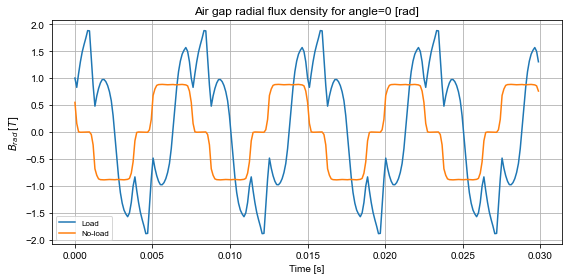

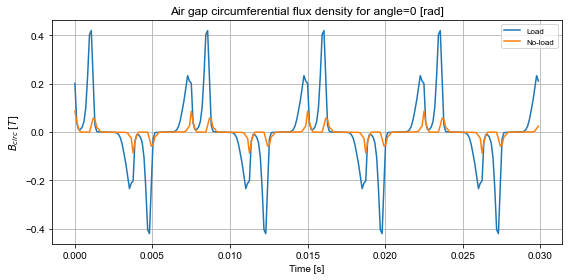

In [35]:
# 시간적 자속 밀도 분포도 비교
out_load.mag.B.plot_2D_Data("time",data_list=[out_noload.mag.B],legend_list=['Load','No-load'])

## FFT of B

#### 1D FFT

Rotating frequency f_mech 33.333333333333336 Hz
Mechanical temporal order : H
Number of freqs_B_r: 33
Temporal Frequency freq_in_mech= [   0.          133.33333333  266.66666667  400.          533.33333333
  666.66666667  800.          933.33333333 1066.66666667 1200.
 1333.33333333 1466.66666667 1600.         1733.33333333 1866.66666667
 2000.         2133.33333333 2266.66666667 2400.         2533.33333333
 2666.66666667 2800.         2933.33333333 3066.66666667 3200.
 3333.33333333 3466.66666667 3600.         3733.33333333 3866.66666667
 4000.         4133.33333333 4266.66666667]
Number of wavenumber: 256
Wavenumber r=: [-512. -508. -504. -500. -496. -492. -488. -484. -480. -476. -472. -468.
 -464. -460. -456. -452. -448. -444. -440. -436. -432. -428. -424. -420.
 -416. -412. -408. -404. -400. -396. -392. -388. -384. -380. -376. -372.
 -368. -364. -360. -356. -352. -348. -344. -340. -336. -332. -328. -324.
 -320. -316. -312. -308. -304. -300. -296. -292. -288. -284. -280. -276.
 -272

C:\Users\TH\anaconda3\envs\py38_pyleecan\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:539: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


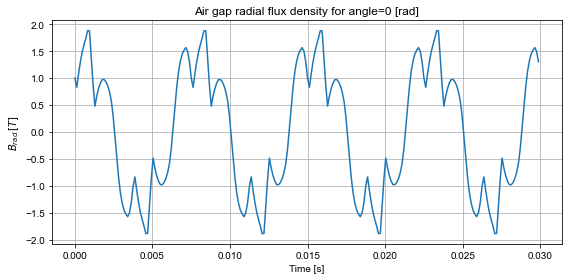

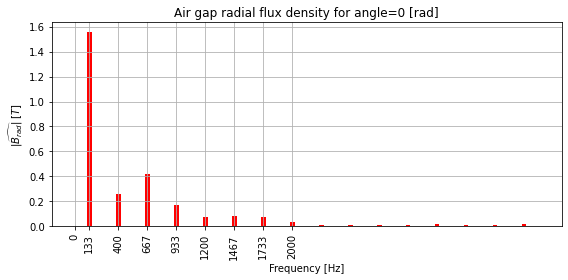

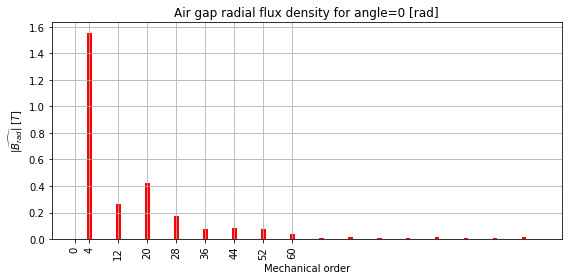

In [36]:
# 원하는 주파수 대역을 확인하기 위한 최소 스텝 확인
# 시간적 전자기력 밀도확인

rpm=2000
poles=8

#기계적 주파수
print('Rotating frequency f_mech', 2000/60, 'Hz')
out_load.mag.B.plot_2D_Data("time", component_list=["radial"])
out_load.mag.B.plot_2D_Data("freqs=[0,6e3]", component_list=["radial"], **dict_2D)

# 원하는 주파수 대역을 확인하기 위한 최소 스텝 확인
print('Mechanical temporal order : H')
out_load.mag.B.plot_2D_Data("freqs->mech_order=[0,200]", component_list=["radial"], **dict_2D)

# Check time-space reconstruction

arg_list = ["freqs", "wavenumber", "mech_order"]
result = out_load.mag.B.get_rphiz_along(*arg_list)
result_freq = out_load.mag.B.get_rphiz_along(*arg_list)

B_r_freq = result_freq["radial"]
freqs_B_r = result_freq["freqs"]
wavenumber_B_r = result_freq["wavenumber"]
Nf = len(freqs_B_r)
Nr = len(wavenumber_B_r)

print('Number of freqs_B_r:',Nf)
print('Temporal Frequency freq_in_mech=',freqs_B_r)
print('Number of wavenumber:',Nr)
print('Wavenumber r=:',wavenumber_B_r) # number of Wavenumber should be half of spatial data from Nyquist Theorem 

C:\Users\TH\anaconda3\envs\py38_pyleecan\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:539: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


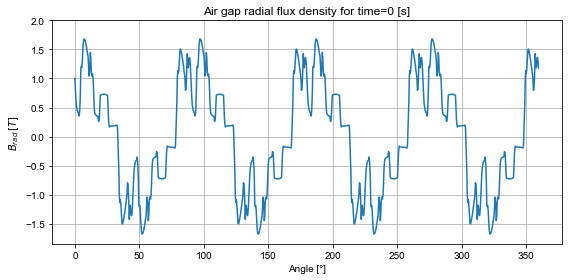

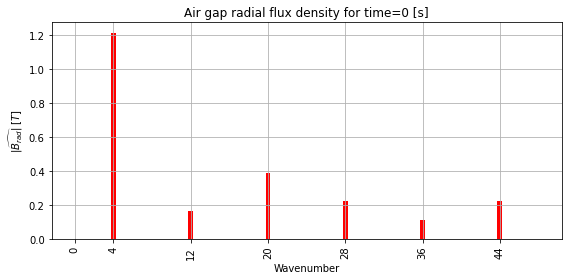

In [37]:
# 방사방향 자속 밀도 공간적 FFT
out_load.mag.B.plot_2D_Data("angle{°}", component_list=["radial"],y_max=2)
out_load.mag.B.plot_2D_Data("wavenumber=[0,50]", component_list=["radial"], **dict_2D)

#### 2D FFT(3D view)

DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x000001964A7EF850>
DEBUG:matplotlib.colorbar:Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x000001964A7EF850> on colorbar
DEBUG:matplotlib.colorbar:Setting pcolormesh
C:\Users\TH\anaconda3\envs\py38_pyleecan\lib\site-packages\SciDataTool\Functions\Plot\plot_3D.py:374: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x000001964A5CBD60>
DEBUG:matplotlib.colorbar:Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x000001964A5CBD60> on colorbar
DEBUG:matplotlib.colorbar:Setting pcolormesh
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x000001964A5E1640>
DEBUG:matplotlib.colorbar:Using auto colorbar locator <ma

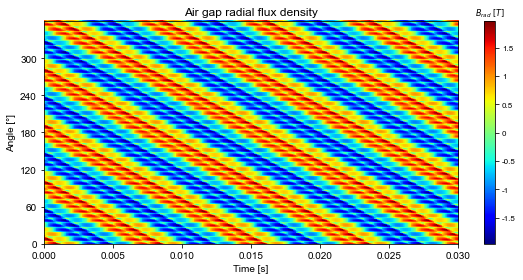

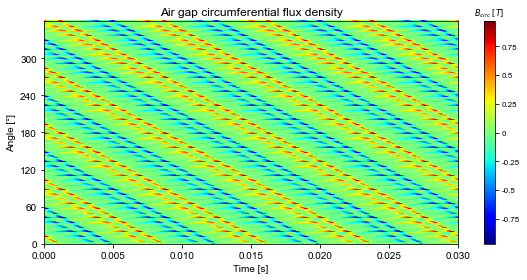

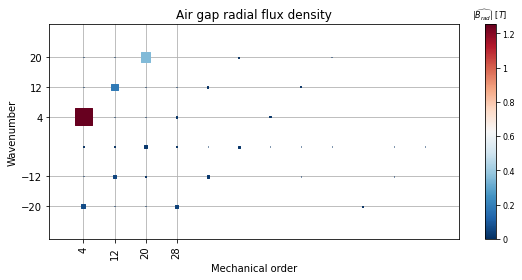

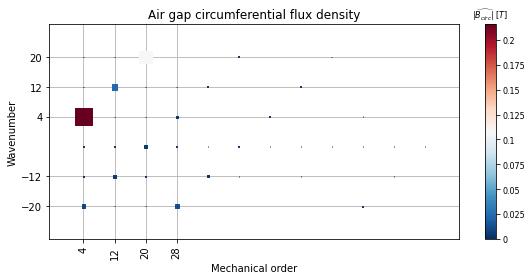

In [38]:
# Angle/Time → WaveNumber/mech_order

out_load.mag.B.plot_3D_Data("time", "angle{°}", is_2D_view=True,x_max=0.03)

out_load.mag.B.plot_3D_Data(
    "freqs->mech_order=[0,96]",
    "wavenumber=[-24,24]",
    N_stem=100,
   
    component_list=["radial"],
    is_2D_view=True,
    **dict_3D
)

out_load.mag.B.plot_3D_Data(
    "freqs->mech_order=[0,96]",
    "wavenumber=[-24,24]",
    N_stem=100,
   
    component_list=["tangential"],
    is_2D_view=True,
    **dict_3D
)


# Plot & Data Check Electromagnetic Force Density[P]


Force 추상 클래스를 사용하면 힘을 계산하는 다양한 방법을 정의할 수 있습니다.

ForceMT 클래스는 Force 클래스에서 상속됩니다. ForceMT는 Maxwell 응력 텐서 \[[source](https://eomys.com/IMG/pdf/comparison-main-magnetic.pdf)\]를 기반으로 하는 공극 표면력을 계산합니다.

여기서 우리는 힘 계산 없이 자기 시뮬레이션의 결과를 얻습니다. Force 모듈은 초기화되고 단독으로 실행됩니다.
시뮬레이션이 완료되면 결과가 출력의 force 부분(예: _myResults.force_ )에 저장되고 다른 플롯을 호출할 수 있습니다. 이 개체에는 다음이 포함됩니다.
- *시간*: 시간 축
- *각도*: 각도 위치 축
- *AGSF*: 에어갭 표면력(방사형 및 접선 성분)
    
**출력** 개체는 결과를 쉽게 시각화하기 위해 다른 플롯을 포함합니다. 

## Data check(Load vs No load)


In [39]:
# 자속밀도를 통해 전자기력 밀도 계산 (매트랩 실습)

out_dict=dict()
Rag=out_load.mag.Rag
out_dict['Rag']=Rag

output=simu2.force.parent.parent
axes_dict=simu2.force.comp_axes(output)

#시간축과 공간축 정의
Angle = axes_dict["angle"]
Time = axes_dict["time"]

#공간축 벡터 
is_periodicity_a, is_antiper_a = Angle.get_periodicity()
angle = Angle.get_values(
    is_oneperiod=is_periodicity_a,
    is_antiperiod=is_antiper_a and is_periodicity_a,
)


#시간축 벡터
is_periodicity_t, is_antiper_t = Time.get_periodicity()
time = Time.get_values(
    is_oneperiod=is_periodicity_t,
    is_antiperiod=is_antiper_t and is_periodicity_t,
)


#자속밀도 불러오기
Brphiz = output.mag.B.get_rphiz_along(
    "time=axis_data",
    "angle=axis_data",
    axis_data={"time": time, "angle": angle},
)

Br = Brphiz["radial"]
Bt = Brphiz["tangential"]
# Bz = Brphiz["axial"]


#공기 투자율
mu_0 = 4 * pi * 1e-7

# 2차원
out_dict["AGSF_r"] = -(Br * Br - Bt * Bt) / (2 * mu_0)
out_dict["AGSF_t"] = -Br * Bt / mu_0

print(Br)
print(Bt)
print(out_dict)
# C:\Users\TH\anaconda3\envs\py38_pyleecan\Lib\site-packages\pyleecan\Results\IPMSM_AGSF_spectrum_load\Femm

[[ 1.00189338  0.81188238  0.65614792 ... -1.36328366 -1.30809348
  -1.17823443]
 [ 0.82992168  0.81419322  0.81201544 ... -1.05905704 -0.95135847
  -0.85587395]
 [ 1.08192617  1.08600797  1.08345521 ... -1.03301122 -1.06852151
  -1.07638543]
 ...
 [-1.56817794 -1.54306186 -1.44396669 ...  1.59124753  1.61395453
   1.58920862]
 [-1.49706419 -1.40938461 -1.26230196 ...  1.60599523  1.61215327
   1.56350915]
 [-1.30430082 -1.20502103 -1.06379628 ...  1.52824661  1.49617954
   1.41004239]]
[[ 0.20176832  0.15078571  0.10523556 ... -0.41227659 -0.30429981
  -0.22618726]
 [ 0.03813372  0.01207266  0.00328501 ... -0.3399288  -0.18454077
  -0.07452481]
 [ 0.01021207  0.00356579  0.00140665 ... -0.08956059 -0.0257071
  -0.01018696]
 ...
 [-0.18167654 -0.1130758  -0.08872884 ...  0.27078271  0.20653468
   0.16402571]
 [-0.23345984 -0.15723878 -0.12612597 ...  0.34604292  0.2768739
   0.22687176]
 [-0.21106868 -0.13998254 -0.1250977  ...  0.42287945  0.33147332
   0.24797955]]
{'Rag': 0.080575, 

C:\Users\TH\anaconda3\envs\py38_pyleecan\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:539: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\TH\anaconda3\envs\py38_pyleecan\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:539: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\TH\anaconda3\envs\py38_pyleecan\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:539: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\TH\anaconda3\envs\py38_pyleecan\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:539: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show t

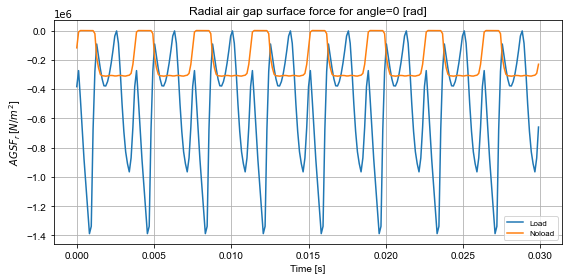

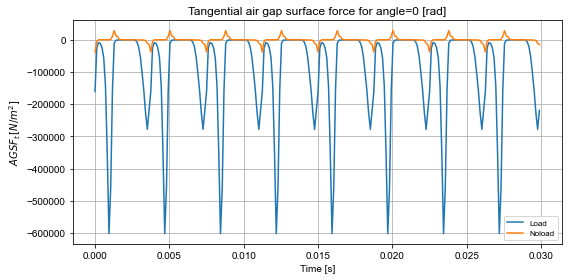

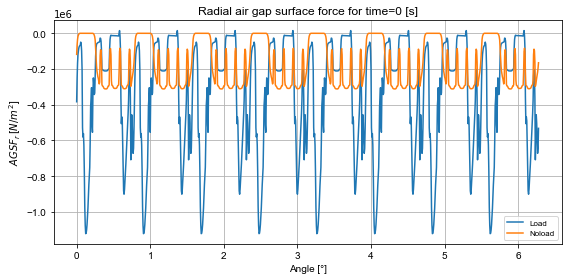

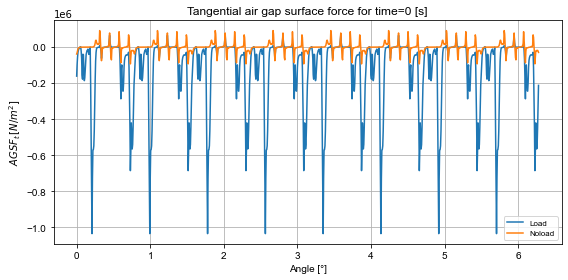

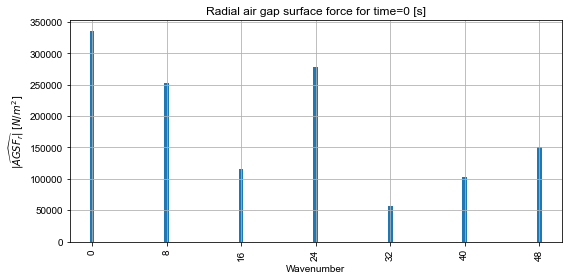

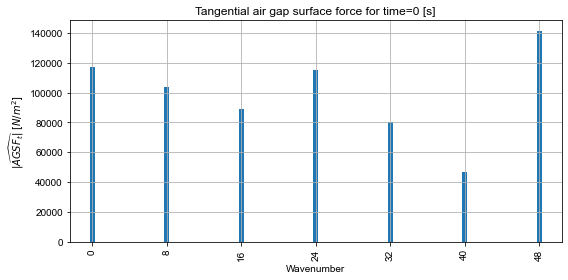

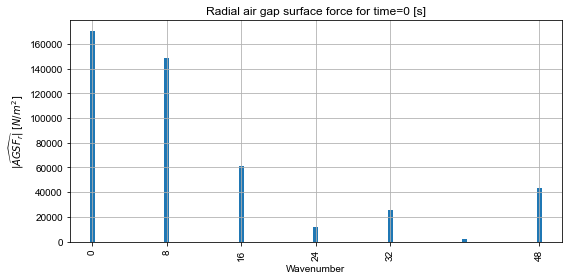

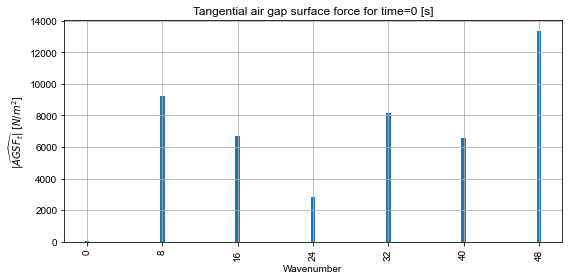

In [40]:
# 부하 무부하 해석 결과 비교

AGSF_load.plot_2D_Data(
    "time", component_list=["radial"], data_list=[AGSF_noload], legend_list=["Load", "Noload"],is_auto_range=False
)
#---------------------------------------------------------------
AGSF_load.plot_2D_Data(
    "time", component_list=["tangential"], data_list=[AGSF_noload], legend_list=["Load", "Noload"]
)


#---------------------------------------------------------------
# compare load and noload
AGSF_load.plot_2D_Data(
    "angle", component_list=["radial"], data_list=[AGSF_noload], legend_list=["Load", "Noload"],is_auto_range=False
)
#---------------------------------------------------------------
AGSF_load.plot_2D_Data(
    "angle", component_list=["tangential"], data_list=[AGSF_noload], legend_list=["Load", "Noload"]
)


AGSF_load.plot_2D_Data(
    "wavenumber=[0,50]",
    component_list=["radial"],
)

AGSF_load.plot_2D_Data(
    "wavenumber=[0,50]",
    component_list=["tangential"],
)

AGSF_noload.plot_2D_Data(
    "wavenumber=[0,50]",
    component_list=["radial"],
)

AGSF_noload.plot_2D_Data(
    "wavenumber=[0,50]",
    component_list=["tangential"],
)




DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x000001964A8AB880>
DEBUG:matplotlib.colorbar:Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x000001964A8AB880> on colorbar
DEBUG:matplotlib.colorbar:Setting pcolormesh
C:\Users\TH\anaconda3\envs\py38_pyleecan\lib\site-packages\SciDataTool\Functions\Plot\plot_3D.py:374: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x000001964A4A9F70>
DEBUG:matplotlib.colorbar:Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x000001964A4A9F70> on colorbar
DEBUG:matplotlib.colorbar:Setting pcolormesh


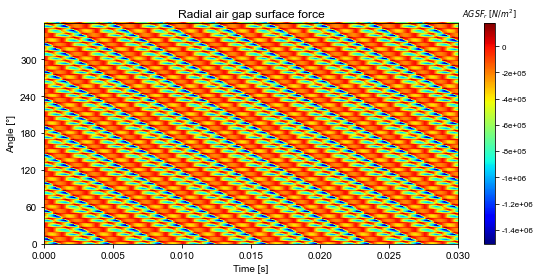

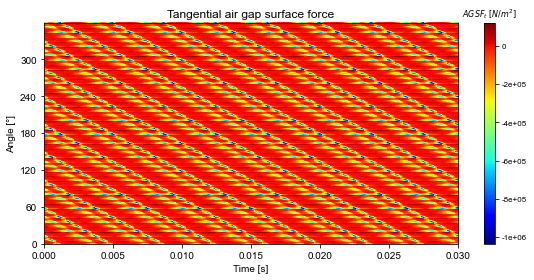

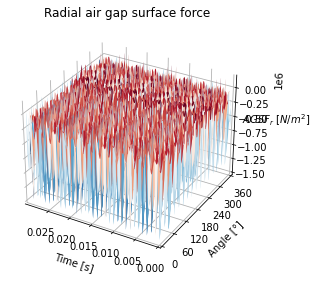

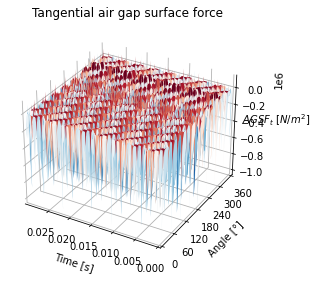

In [41]:
# Force 확인 - 부하해석 결과 2D (Angle / Time)

AGSF_load.plot_3D_Data("time", "angle{°}", is_2D_view=True,x_max=0.03)
AGSF_load.plot_3D_Data("time", "angle{°}", is_2D_view=False, **dict_3D)

#------------------------------------------------------



DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x0000019649CD86A0>
DEBUG:matplotlib.colorbar:Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x0000019649CD86A0> on colorbar
DEBUG:matplotlib.colorbar:Setting pcolormesh
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x000001964A8F72E0>
DEBUG:matplotlib.colorbar:Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x000001964A8F72E0> on colorbar
DEBUG:matplotlib.colorbar:Setting pcolormesh


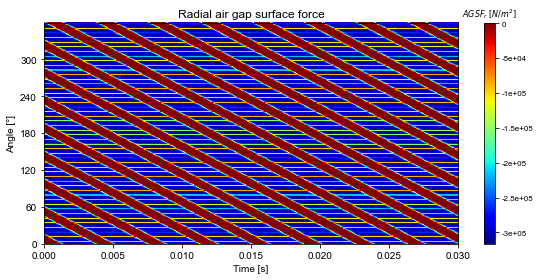

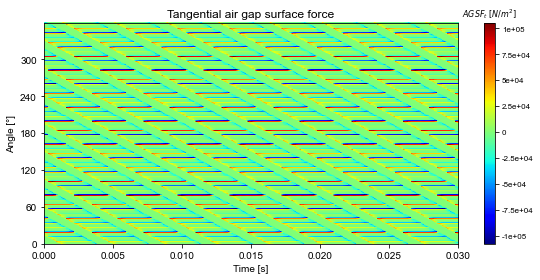

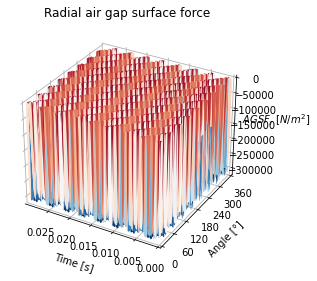

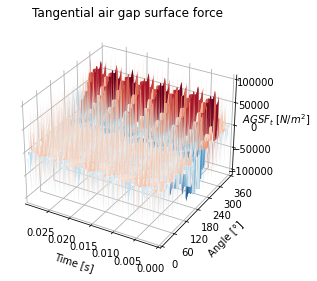

In [42]:
# 무부하 해석 결과 2D (Angle / Time)

AGSF_noload.plot_3D_Data("time", "angle{°}", is_2D_view=True,x_max=0.03)
AGSF_noload.plot_3D_Data("time", "angle{°}", is_2D_view=False, **dict_3D)


#------------------------------------------------------

## FFT of P

### 2D FFT

DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x0000019643B6D3A0>
DEBUG:matplotlib.colorbar:Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x0000019643B6D3A0> on colorbar
DEBUG:matplotlib.colorbar:Setting pcolormesh
C:\Users\TH\anaconda3\envs\py38_pyleecan\lib\site-packages\SciDataTool\Functions\Plot\plot_4D.py:295: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x0000019645102550>
DEBUG:matplotlib.colorbar:Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x0000019645102550> on colorbar
DEBUG:matplotlib.colorbar:Setting pcolormesh
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x000001964A115910>
DEBUG:matplotlib.colorbar:Using auto colorbar locator <ma

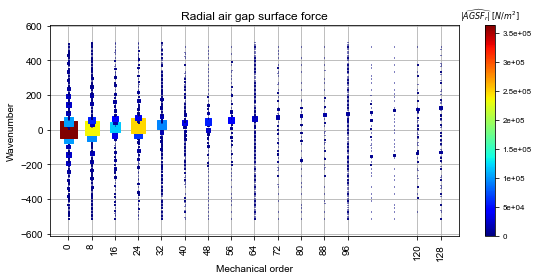

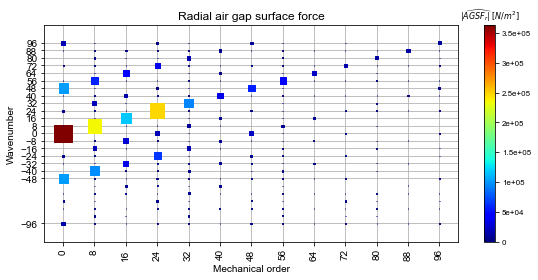

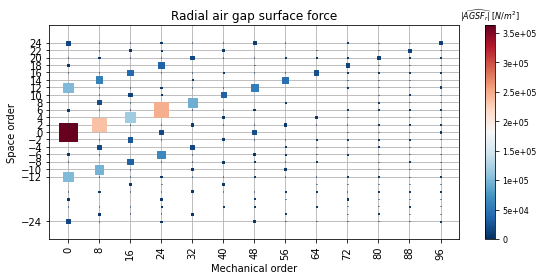

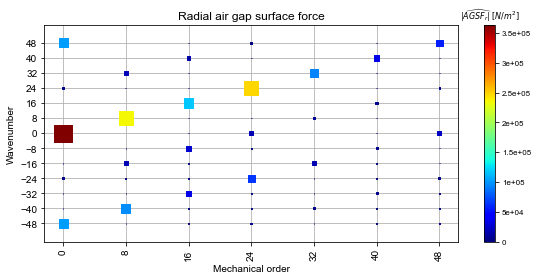

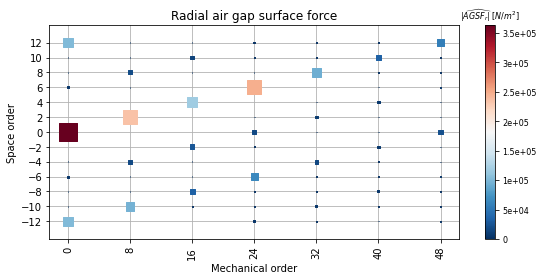

In [43]:
# 방사방향 전체 파형 2D (Mech_order / wavenumber)

AGSF_load.plot_3D_Data(
    "freqs->mech_order",
    "wavenumber",
    N_stem=100,
    component_list=["radial"],
    is_2D_view=True,
#     **dict_3D
)

# mech_order - wavenumber
AGSF_load.plot_3D_Data(
    "freqs->mech_order=[0,96]",
    "wavenumber=[-100,100]",
    N_stem=100,
    component_list=["radial"],
    is_2D_view=True,
#     **dict_3D
)

# mech_order - space_order
AGSF_load.plot_3D_Data(
    "freqs->mech_order=[0,96]",
    "wavenumber->space_order=[-25,25]",
    N_stem=100,
    component_list=["radial"],
    is_2D_view=True,
    **dict_3D

)

# mech_order - wavenumber
AGSF_load.plot_3D_Data(
    "freqs->mech_order=[0,48]",
    "wavenumber=[-50,50]",
    N_stem=100,
    component_list=["radial"],
    is_2D_view=True,
#     **dict_3D
)

# mech_order - space_order
AGSF_load.plot_3D_Data(
    "freqs->mech_order=[0,48]",
    "wavenumber->space_order=[-12,12]",
    N_stem=100,
    component_list=["radial"],
    is_2D_view=True,
    **dict_3D

)



DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x000001964A4DE520>
DEBUG:matplotlib.colorbar:Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x000001964A4DE520> on colorbar
DEBUG:matplotlib.colorbar:Setting pcolormesh
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x000001964A747250>
DEBUG:matplotlib.colorbar:Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x000001964A747250> on colorbar
DEBUG:matplotlib.colorbar:Setting pcolormesh
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x000001964A1ECA60>
DEBUG:matplotlib.colorbar:Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x000001964A1ECA60> on colorbar
DEBUG:matplotlib.colorbar:Setting pcolormesh
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x000001964505E5E0>
DEBUG:matplotlib.colorb

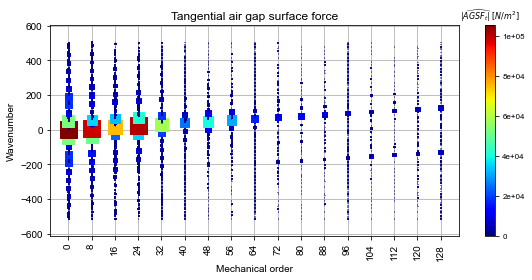

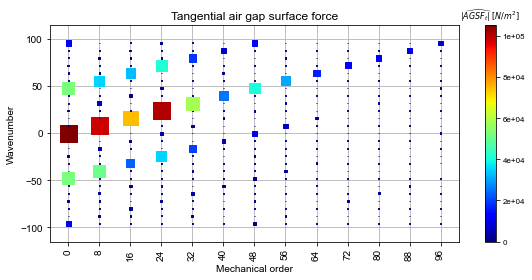

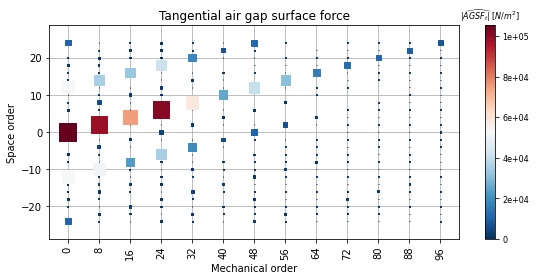

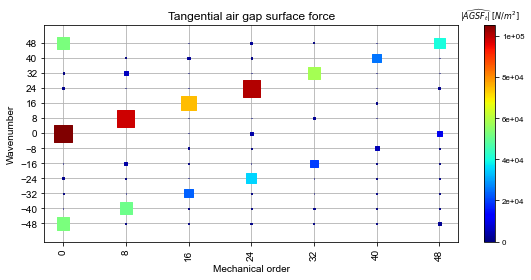

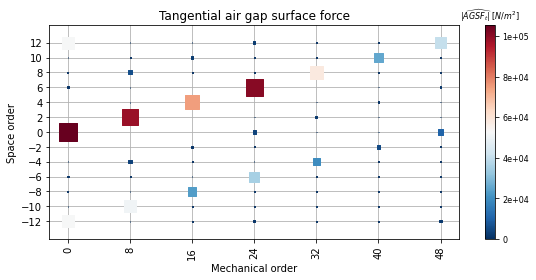

In [44]:
# 접선방향 전체 파형 2D (Mech_order / wavenumber)
AGSF_load.plot_3D_Data(
    "freqs->mech_order",
    "wavenumber",
    N_stem=100,
    component_list=["tangential"],
    is_2D_view=True,
#     **dict_3D
)

# mech_order - wavenumber
AGSF_load.plot_3D_Data(
    "freqs->mech_order=[0,96]",
    "wavenumber=[-100,100]",
    N_stem=100,
    component_list=["tangential"],
    is_2D_view=True,
#     **dict_3D
)

# mech_order - space_order
AGSF_load.plot_3D_Data(
    "freqs->mech_order=[0,96]",
    "wavenumber->space_order=[-25,25]",
    N_stem=100,
    component_list=["tangential"],
    is_2D_view=True,
    **dict_3D

)

# mech_order - wavenumber
AGSF_load.plot_3D_Data(
    "freqs->mech_order=[0,48]",
    "wavenumber=[-50,50]",
    N_stem=100,
    component_list=["tangential"],
    is_2D_view=True,
#     **dict_3D
)

# mech_order - space_order
AGSF_load.plot_3D_Data(
    "freqs->mech_order=[0,48]",
    "wavenumber->space_order=[-12,12]",
    N_stem=100,
    component_list=["tangential"],
    is_2D_view=True,
    **dict_3D

)



다음 플롯은 시간과 각도에 따른 방사형 에어 갭 표면력을 표시합니다.

DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x000001964A5F3040>
DEBUG:matplotlib.colorbar:Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x000001964A5F3040> on colorbar
DEBUG:matplotlib.colorbar:Setting pcolormesh
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x0000019643D39760>
DEBUG:matplotlib.colorbar:Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x0000019643D39760> on colorbar
DEBUG:matplotlib.colorbar:Setting pcolormesh


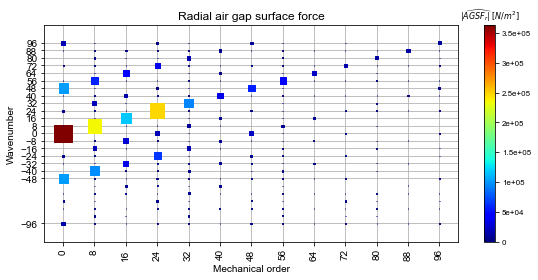

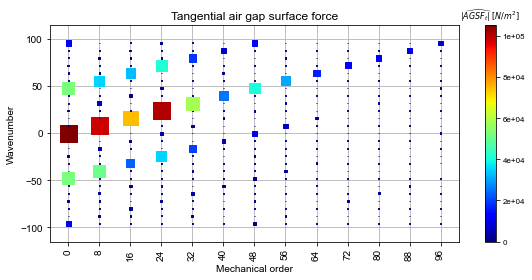

In [45]:
# 방사 방향 및 접선방향 AGSF 비교

# 방사방향 mech_order - wavenumber
AGSF_load.plot_3D_Data(
    "freqs->mech_order=[0,96]",
    "wavenumber=[-100,100]",
    N_stem=100,
    component_list=["radial"],
    is_2D_view=True,
#     **dict_3D
)

# 접선 방향 mech_order - wavenumber
AGSF_load.plot_3D_Data(
    "freqs->mech_order=[0,96]",
    "wavenumber=[-100,100]",
    N_stem=100,
    component_list=["tangential"],
    is_2D_view=True,
#     **dict_3D
)

#------------------------------------------------------

 
이 튜토리얼과 관련된 노트북은 [GitHub](https://github.com/Eomys/pyleecan/tree/master/Tutorials/tuto_Force.ipynb)에서 볼 수 있습니다.

# Force vs Torque

C:\Users\TH\anaconda3\envs\py38_pyleecan\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:539: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x0000019644E96100>
DEBUG:matplotlib.colorbar:Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x0000019644E96100> on colorbar
DEBUG:matplotlib.colorbar:Setting pcolormesh
C:\Users\TH\anaconda3\envs\py38_pyleecan\lib\site-packages\SciDataTool\Functions\Plot\plot_4D.py:295: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


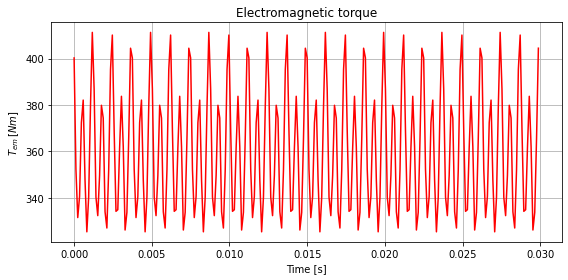

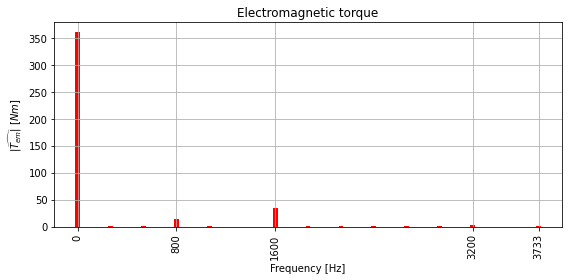

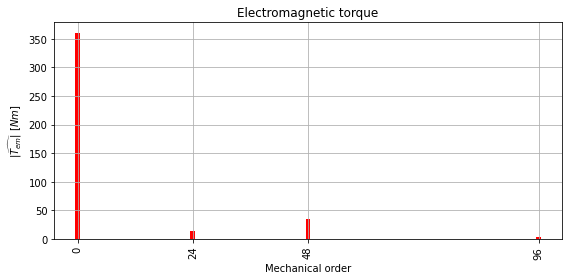

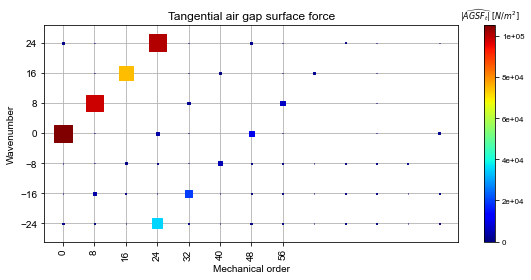

In [46]:
# 토크 파형
out_load.mag.Tem.plot_2D_Data("time", **dict_2D)

# 토크 파형 FFT
out_load.mag.Tem.plot_2D_Data("freqs", **dict_2D)
out_load.mag.Tem.plot_2D_Data("freqs->mech_order=[-48,96]", **dict_2D)

# AGSF
AGSF_load.plot_3D_Data(
    "freqs->mech_order=[0,96]",
    "wavenumber=[-24,24]",
    N_stem=100,
    component_list=["tangential"],
    is_2D_view=True,
)

